In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gensimtopic/selected_papers.csv


In [2]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import spacy
from nltk.corpus import stopwords

# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
gensim.__version__

'3.8.3'

In [4]:
# # import nltk
# # nltk.download('stopwords')
# #python -m spacy download en
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
# os.listdir('/kaggle/working')

--2020-10-30 13:20:30--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.50MB/s    in 2.8s    

2020-10-30 13:20:34 (5.50 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [5]:
OUT_PATH = '/kaggle/working'
mallet_path = os.path.join(OUT_PATH, './mallet-2.0.8/bin/mallet')

In [6]:
df = pd.read_csv("../input/gensimtopic/selected_papers.csv")

In [7]:
df['abstract'] = df['abstract'].str.strip()
# Convert to list
data = df.abstract.values.tolist()

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [11]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_phraser = gensim.models.phrases.Phraser(bigram)
trigram_phraser = gensim.models.phrases.Phraser(trigram)

CPU times: user 2min 16s, sys: 528 ms, total: 2min 17s
Wall time: 2min 17s


In [12]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_phraser[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
%%time
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams)

CPU times: user 7min 22s, sys: 2.3 s, total: 7min 24s
Wall time: 7min 24s


In [14]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 2), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1)]]
CPU times: user 14.7 s, sys: 359 ms, total: 15 s
Wall time: 15.1 s


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=20, limit=201, step=20)

CPU times: user 8min 1s, sys: 17.9 s, total: 8min 19s
Wall time: 2h 39min 42s


In [17]:
import pickle 

with open('coherence_values.pickle', 'wb') as f:
  pickle.dump(coherence_values, f)


with open('models.pickle', 'wb') as f:
  pickle.dump(model_list, f)



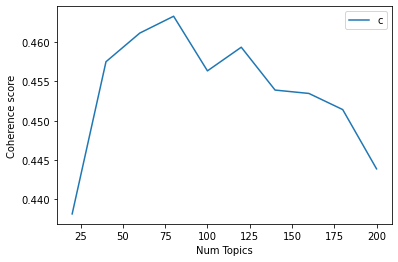

In [18]:
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
limit=201; start=20; step=20;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()